## How to Make a Shot Quality Model

### What is a Shot Quality Model

In general, a shot quality model's goal is to predict how many points a player will score based on a shot (PPS). There are three kinds of shots a player can take, FT, FG2, and FG3. You could make three separate models or one model that works for all three kinds of shots. One nice and/or challenging aspect of these models is that you're more or less entirely bound between 0-3. If your PPS model is predicting 7, there might be an issue. 

One well documented public example of a good shot quality model is KOBE, developed by [Krisha Narsu](http://twitter.com/knarsu3) and [published at Nylon Calculus](https://fansided.com/2015/09/28/introducing-kobe-a-measure-of-shot-quality/). The model we develop here will not be as good, but will also not be named after a Lakers player, so that's a plus. In fact, we can go ahead and name ours **EMBIID**, or **E**xtremely **M**ediocre to **B**ad **I**ntroductory scor**I**ng mo**D**el.

We're going to be using exclusively shot data derived from play-by-play data - no tracking or demographic info here. The shots are 100,000 random fieldgoal attempts from the 2018 and 2019 regular seasons. 

### Get the Data Set Up

We're going to read in the data first and just sanity check that it looks like shot data. Secondly, as this is spatial data, we're going to visualize some shots. I cannot emphasize enough how important it is to be 10000% confident in your coordinate system when you use spatial data. Spending 8hrs modeling and then realizing you need to change the CRS or do a bunch of rotations is not a good feeling.

             event_team            home_team               away_team  \
0       Detroit Pistons      Detroit Pistons       Charlotte Hornets   
1        Boston Celtics       Boston Celtics         Toronto Raptors   
2        Denver Nuggets       Denver Nuggets  Minnesota Timberwolves   
3          Phoenix Suns         Phoenix Suns   Oklahoma City Thunder   
4  Los Angeles Clippers  Cleveland Cavaliers    Los Angeles Clippers   

                   game_date      event_type quarter_time  quarter  \
0  2018-11-11T20:30:00+00:00    twopointmiss        10:04        3   
1  2018-11-17T00:00:00+00:00  threepointmade        10:11        2   
2  2020-02-23T23:00:00+00:00    twopointmade         6:13        2   
3  2018-11-18T02:00:00+00:00  threepointmiss         9:08        3   
4  2020-02-10T00:30:00+00:00    twopointmiss         3:09        4   

                                   event_description     player_name  \
0              Andre Drummond misses two point layup  Andre Drummond   
1 

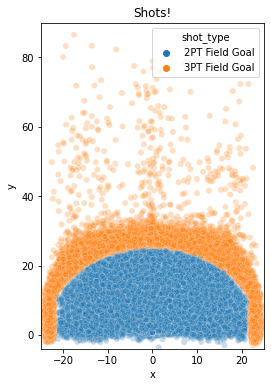

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

all_shots = pd.read_csv("data/shots.csv")
print(all_shots.head())

f, ax = plt.subplots(figsize=(4, 6))
#plt.axis('equal')
plt.xlim(-25, 25)
plt.ylim(-4, 90)
plt.title("Shots!")
sns.scatterplot(
    data=all_shots, 
    x="x", 
    y="y", 
    hue="shot_type",
    alpha = 0.25)
plt.show()

Well, that certainly looks correct or close enough. However, there are quite a few heaves that we probably want to take out of the model since we probably(?) don't care about those. Let's limit it to shots 32 feet and closer (the top line of the little court). We only lose about 600 shots by doing this, so shouldn't be an issue.

In [2]:
print(all_shots.shape)

shots = all_shots.loc[all_shots['shot_distance'] <= 32]

print(shots.shape)

(100000, 18)
(99391, 18)


## Pre-Modeling Interlude

Before we get started, a brief soapbox moment. It can be tempting to fire up TensorFlow and get crazy here, but starting simple and improving your model iteratively is a good idea. Go small to big, as you might find out you don't need a 40 layer NN to get the job done. (Although sometimes you do).

## Modeling

The good news about a PPS model is that there is an extremely obvious first pass model to either test or at least consider. Very slight math warning approaching.

$xPPS = {\beta_0} + {\beta_1} * FG2 + {\beta_2} * FG3$

This is our starting point. This model takes binary flags for FG2 and FG3 and then returns an expected point per shot value (xPPS). Although, let's consider if we actually need an intercept here - what would the xPPS be if FG2 = 0 and FG3 = 0? It would be zero, so we can actually get rid of the intercept entirely. You could of course also remove one of FG2 or FG3 as well and keep the intercept, but I like it this way for presentation purposes. EMBIID v1.0 is presented below.

$xPPS = {\beta_1} * FG2 + {\beta_2} * FG3$


Now, let's use this model setup to train on 75% of the data and test on 25% of the data and see how we do. Sidenote, I'm doing this with statsmodels because sklearn doesn't have linear regression summary tables which makes me insane.

In [3]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
pd.options.mode.chained_assignment = None

shots['fg2'] = np.where(shots['shot_type'] == '2PT Field Goal', 1, 0)
shots['fg3'] = np.where(shots['shot_type'] == '3PT Field Goal', 1, 0)

train_shots, test_shots = train_test_split(shots, train_size=0.75, random_state=42)

## NOTE THAT Y COMES FIRST UNLIKE SKLEARN
y_train = train_shots['points']
X_train = train_shots[['fg2', 'fg3']]
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.218
Date:                Tue, 05 Jan 2021   Prob (F-statistic):              0.136
Time:                        16:39:42   Log-Likelihood:            -1.1838e+05
No. Observations:               74543   AIC:                         2.368e+05
Df Residuals:                   74541   BIC:                         2.368e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
fg2            1.1010      0.006    200.103      0.000       1.090       1.112
fg3            1.0877      0.007    154.276      0.000       1.074       1.101
==============================================================================
Omnibus:                   383837.877   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8925.388
Skew:                           0.316   Prob(JB):                         0.00
Kurtosis:                       1.427   Cond. No.                         1.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Good news - our model makes sense. Our FG2 and FG3 coefficients are nice here because they're just points per shot! Now before you go ahead and start yelling about how the game has changed, keep in mind that there is **zero** contextualizing information here - just the most basic league wide efficiency model. Now let's test. Also, we're going to do some method chaining here which if you come from the tidyverse will look very comforting.

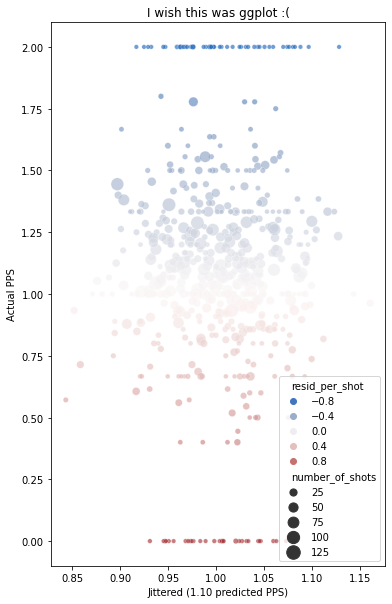

0.219
0.336


In [4]:
from sklearn.metrics import mean_squared_error
y_test = test_shots['points']
X_test = test_shots[['fg2', 'fg3']]
test_shots['pred_PPS'] = model.predict(X_test).values

results_by_player = (test_shots
                     .groupby(['player_name', 'shot_type'])[['points', 'pred_PPS']]
                     .agg({'points': ['sum', 'count'],
                           'pred_PPS': ['sum']}))

results_by_player.columns = ['total_points', 'number_of_shots', 'total_pred_points']
results_by_player = results_by_player.reset_index()
results_by_player['total_resid'] = results_by_player['total_pred_points'] - results_by_player['total_points']
results_by_player['resid_per_shot'] = results_by_player['total_resid']/results_by_player['number_of_shots']
results_by_player['pps_actual'] = results_by_player['total_points']/results_by_player['number_of_shots']
results_by_player['pps_pred'] = results_by_player['total_pred_points']/results_by_player['number_of_shots']

twos = results_by_player.loc[results_by_player['shot_type'] == "2PT Field Goal"]
threes = results_by_player.loc[results_by_player['shot_type'] == "3PT Field Goal"]

jittered = np.random.normal(1, 0.05, len(twos['pps_actual']))

f, ax = plt.subplots(figsize=(6, 10))
plt.title("I wish this was ggplot :(")
plt.ylabel("Actual PPS")
plt.xlabel("Jittered (1.10 predicted PPS)")
sns.scatterplot(data=twos,
                y="pps_actual",
                x=jittered,
                hue="resid_per_shot",
                size="number_of_shots",
                alpha=0.65,
                sizes=(20, 200),
                palette=sns.color_palette("vlag", as_cmap=True)
                )
plt.show()

two_error = np.round(mean_squared_error(y_true=twos['pps_actual'],
                               y_pred=twos['pps_pred'],
                               sample_weight=twos['number_of_shots'],
                               squared=False), 3)

three_error = np.round(mean_squared_error(y_true=threes['pps_actual'],
                                 y_pred=threes['pps_pred'],
                                 sample_weight=threes['number_of_shots'],
                                 squared=False), 3)

print(two_error) ## I have no idea how to include variables in the markdown cell
print(three_error) ## I have no idea how to include variables in the markdown cell

Well our attempted weighted RMSE for twos is 0.219 and 0.336 for threes. Not particularly great, but RMSE might also not be the best way to evaluate this model (not going to be covered here, but this is something to consider)! But, that's to be expected as we're treating every single FG2 the same and every FG3 the same. Let's add some spatial information in and see if we do better.

In [5]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
pd.options.mode.chained_assignment = None

## NOTE THAT Y COMES FIRST UNLIKE SKLEARN
X_train = train_shots[['fg2', 'fg3', 'shot_distance']]
X_test = test_shots[['fg2', 'fg3', 'shot_distance']]
model = sm.OLS(y_train, X_train).fit()
model.summary()
test_shots['pred_PPS'] = model.predict(X_test).values

results_by_player = (test_shots
                     .groupby(['player_name', 'shot_type'])[['points', 'pred_PPS']]
                     .agg({'points': ['sum', 'count'],
                           'pred_PPS': ['sum']}))

results_by_player.columns = ['total_points', 'number_of_shots', 'total_pred_points']
results_by_player = results_by_player.reset_index()
results_by_player['total_resid'] = results_by_player['total_pred_points'] - results_by_player['total_points']
results_by_player['resid_per_shot'] = results_by_player['total_resid']/results_by_player['number_of_shots']
results_by_player['pps_actual'] = results_by_player['total_points']/results_by_player['number_of_shots']
results_by_player['pps_pred'] = results_by_player['total_pred_points']/results_by_player['number_of_shots']

twos = results_by_player.loc[results_by_player['shot_type'] == "2PT Field Goal"]
threes = results_by_player.loc[results_by_player['shot_type'] == "3PT Field Goal"]

two_error = np.round(mean_squared_error(y_true=twos['pps_actual'],
                               y_pred=twos['pps_pred'],
                               sample_weight=twos['number_of_shots'],
                               squared=False), 3)

three_error = np.round(mean_squared_error(y_true=threes['pps_actual'],
                                 y_pred=threes['pps_pred'],
                                 sample_weight=threes['number_of_shots'],
                                 squared=False), 3)

print(two_error) ## I have no idea how to include variables in the markdown cell
print(three_error) ## I have no idea how to include variables in the markdown cell

0.197
0.337


This time our RMSE is slightly smaller for twos at 0.197 and more or less the same (0.337) for threes. Better on twos now which makes sense given that a average rim look is far more likely to go in in than an average 19' jumper, almost regardless of context.

However, you might be thinking "Aren't we modeling if a shot goes in or not, an inherently binary (yes/no) task? Can't we use a classifier?". Yes. Yes we can, and I actually prefer that methodology. Let's build EMBIID 3.0 using a logistic classifier. Also, how about another two improvements with some crude feature crafting. We know that in terms of twos, rim FGA are the easiest shots and for threes, it's corner threes (both by distance and that they tend to me assisted more often). So let's make a rim FGA and corner three FGA flag and stick that in there as well. [Hit this link if you need a quick refresher on how to interpret the output (IDRE is awesome)](https://stats.idre.ucla.edu/r/dae/logit-regression/). 

In [6]:
pd.options.mode.chained_assignment = None

shots['rim_fg'] = np.where(shots['shot_distance'] <= 6, 1, 0)
shots['corner_three'] = np.where((shots['fg3'] == 1) & (shots['y'] <= 5), 1, 0)

train_shots, test_shots = train_test_split(shots, train_size=0.75, random_state=42)
y_train = train_shots['shot_made']
X_train = train_shots[['fg2', "shot_distance", "rim_fg", "corner_three"]]
X_train = sm.add_constant(X_train) ## this adds the intercept back in (default is no intercept for sm)
model = sm.GLM(y_train, 
               X_train, 
               family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              shot_made   No. Observations:                74543
Model:                            GLM   Df Residuals:                    74538
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48946.
Date:                Tue, 05 Jan 2021   Deviance:                       97892.
Time:                        16:39:43   Pearson chi2:                 7.45e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2915      0.072      4.041      0.000       0.150       0.433
fg2              -0.1607      0.040     -4.046      0.000      -0.238      -0.083
shot_distance    -0.0329      0.003    -12.471      0.000      -0.038      -0.028
rim_fg            0.6118      0.035     17.590      0.000       0.544       0.680
corner_three      0.0437      0.034      1.277      0.201      -0.023       0.111
=================================================================================
"""

Snazzy. Our two new variables appear to add value to the model (EMBIID 3.0), so let's take a look at some testing results.

In [7]:
X_test = test_shots[['fg2', "shot_distance", "rim_fg", "corner_three"]]
X_test = sm.add_constant(X_test)
preds = model.predict(X_test).values

test_shots['xFG'] = preds
test_shots['xPTS'] = np.where(test_shots['shot_type'] == "2PT Field Goal",
                             2 * test_shots['xFG'],
                             3 * test_shots['xFG'])


#results_by_player = (test_shots
#                     .groupby(['player_name', 'shot_type'])[['points', 'pred_PPS']]
#                     .agg({'points': ['sum', 'count'],
#                           'pred_PPS': ['sum']}))

fg2 = (test_shots
      .groupby(['player_name', 'shot_type'])[['points', 'xPTS', 'shot_made', 'xFG']]
      .agg({'points': ['sum', 'count'],
           'xPTS': ['sum'],
           'shot_made': ['sum'],
           'xFG': ['mean']}))


fg2.columns = ['PTS', 'number_of_shots', 'xPTS', 'number_of_makes', 'xFG%']
fg2 = fg2.reset_index()
fg2 = fg2.loc[fg2['shot_type'] == '2PT Field Goal']
fg2 = fg2.nlargest(10, 'number_of_shots').sort_values('number_of_shots', ascending=False)

fg2['FG%'] = np.round(fg2['number_of_makes']/fg2['number_of_shots'], 3)
fg2['xFG%'] = np.round(fg2['xFG%'], 3)
fg2['xPTS'] = np.round(fg2['xPTS'], 3)
fg2 = fg2.rename(columns = {'player_name': "Player",
                           'number_of_shots': 'FG2A',
                           'number_of_makes': 'FG2M'})
fg2['Shot Making'] = np.round((fg2['PTS'] - fg2['xPTS'])/fg2['FG2A'], 2)
fg2[['Player', 'FG2A', 'FG2M', 'FG%', 'xFG%', 'PTS', 'xPTS', 'Shot Making']]

,Player,FG2A,FG2M,FG%,xFG%,PTS,xPTS,Shot Making
232,DeMar DeRozan,138,72,0.522,0.507,144,139.988,0.03
670,LaMarcus Aldridge,127,68,0.535,0.468,136,118.993,0.13
905,Russell Westbrook,120,56,0.467,0.554,112,133.048,-0.18
787,Montrezl Harrell,119,81,0.681,0.622,162,147.957,0.12
813,Nikola Jokic,118,76,0.644,0.558,152,131.711,0.17
113,CJ McCollum,113,63,0.558,0.512,126,115.792,0.09
167,Collin Sexton,112,57,0.509,0.538,114,120.450,-0.06
684,LeBron James,112,53,0.473,0.547,106,122.524,-0.15
366,Giannis Antetokounmpo,108,78,0.722,0.619,156,133.685,0.21
283,Donovan Mitchell,107,51,0.477,0.532,102,113.910,-0.11


So here we have a table that shows the players with the top ten most FG2A in our test set and their various actual and predicted FG% and points scored. The last column, 'Shot Making' shows on a per shot basis, the differential between that player taking the shot and more or less the league average. LMA is positive because he's quite good at the midrange compared to the rest of the league, whereas someone like Russell Westbrook is significantly negative on a per shot basis. However, as the number one ball handling option on their team, sometimes lead guard types can be forced to take the junk shots or end of clock shots that no one else can get/create for themselves. Also, they might not be on the receiving end of many high quality passes. Just things to think about when using these context free models to make any Big Internet Takes.


Now you have been armed with the tools to explore your own quality models. Think about how to include player level information, matchups, lineups, etc. You can get as crazy as you want to with these. See if you can duplicate some of the information in KOBE (you won't be able to because it's SportVU data) but do your best.
